In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

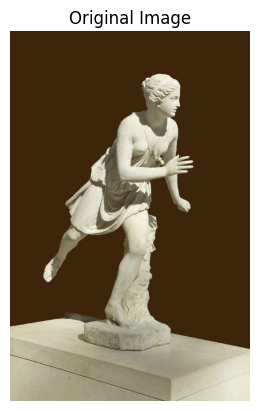

In [2]:

# create stereoscopic sbs pair from a single image
## read image
img = cv2.imread('input.jpg')
h, w = img.shape[:2]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
plt.show()

Using cache found in C:\Users\Hugo/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Hugo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, pl

Loading weights:  None


Using cache found in C:\Users\Hugo/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Using device: cpu


Using cache found in C:\Users\Hugo/.cache\torch\hub\intel-isl_MiDaS_master


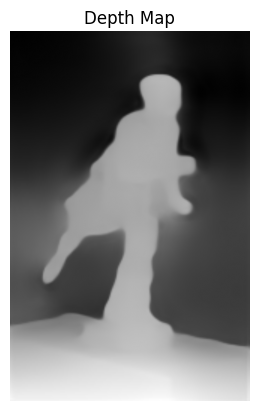

In [3]:
# Load MiDaS model
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
midas.to(device)

# Load transforms
transform = torch.hub.load('intel-isl/MiDaS', 'transforms').small_transform

# Read image
img = cv2.imread('input.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img_rgb).to(device)

# Predict depth
with torch.no_grad():
    prediction = midas(input_batch)
    depth_map = prediction.squeeze().cpu().numpy()

# Normalize and display
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_map = depth_map.astype(np.uint8)
# resize to original image size
depth_map = cv2.resize(depth_map, (w, h))
cv2.imshow('Depth Map', depth_map)
cv2.imwrite('depth_map.jpg', depth_map)

# show depth map using matplotlib
plt.imshow(depth_map, cmap='gray')
plt.axis('off')
plt.title('Depth Map')
plt.show()

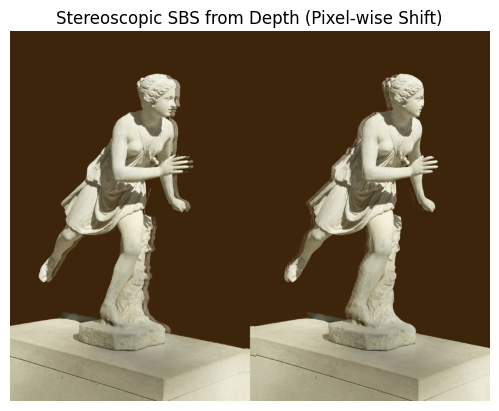

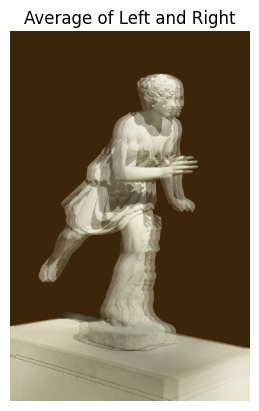

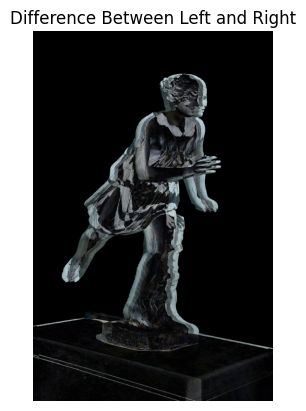

In [ ]:
# Create stereoscopic SBS pair using depth map for pixel-wise shift
import numpy as np
import cv2

# Parameters
max_shift = 30  # maximum pixel shift for closest objects (tune as needed)

# Ensure depth_map and img are available from previous cells
h, w = depth_map.shape
left_img = np.zeros_like(img)
right_img = np.zeros_like(img)

# Normalize depth map to [0, 1]
depth_norm = cv2.normalize(depth_map.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)

for y in range(h):
    for x in range(w):
        shift = int(depth_norm[y, x] * max_shift)
        # Left image: shift pixel to the left
        lx = x - shift
        if 0 <= lx < w:
            left_img[y, lx] = img[y, x]
        # Right image: shift pixel to the right
        rx = x + shift
        if 0 <= rx < w:
            right_img[y, rx] = img[y, x]

#### FILL ####
# V0: FROM ORIGINAL: not working
# # Fill empty pixels (optional: inpaint or blur)
# left_img[left_img.sum(axis=2) == 0] = img[left_img.sum(axis=2) == 0]
# right_img[right_img.sum(axis=2) == 0] = img[right_img.sum(axis=2) == 0]

# V1: Simple propagation
# Fill blanks by propagating from left (for left_img) and right (for right_img)

# --- Left image: propagate values from left to right ---
for y in range(h):
    last_pixel = None
    for x in range(w):
        if np.all(left_img[y, x] == 0):  # blank
            if last_pixel is not None:
                left_img[y, x] = last_pixel
        else:
            last_pixel = left_img[y, x]

# --- Right image: propagate values from right to left ---
for y in range(h):
    last_pixel = None
    for x in range(w-1, -1, -1):  # sweep right→left
        if np.all(right_img[y, x] == 0):  # blank
            if last_pixel is not None:
                right_img[y, x] = last_pixel
        else:
            last_pixel = right_img[y, x]

# Concatenate and display
sbs_depth = cv2.hconcat([left_img, right_img])
# cv2.imshow('Stereoscopic SBS from Depth', sbs_depth)
cv2.imwrite('stereoscopic_sbs_from_depth_pixelwise.jpg', sbs_depth)

plt.imshow(cv2.cvtColor(sbs_depth, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Stereoscopic SBS from Depth (Pixel-wise Shift)')
plt.show()

avg_img = cv2.addWeighted(left_img, 0.5, right_img, 0.5, 0)
# cv2.imshow('Average of L/R', avg_img)
cv2.imwrite('stereo_average.jpg', avg_img)

plt.imshow(cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Average of Left and Right')
plt.show()

# Absolute color difference between left and right
diff_img = cv2.absdiff(left_img, right_img)

# cv2.imshow('Difference (L vs R)', diff_img)
cv2.imwrite('stereo_difference.jpg', diff_img)

plt.imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Difference Between Left and Right')
plt.show()